# Product Analytics 2025: Домашнее задание 11

ЗАДАНИЕ: Веб-сервис, управления личными слотами на консультации или календарь для записи на
консультации с возможностью приема денег за консультацию. 
Данный бизнес - это стартап, который существует всего три месяца, май, июнь и июль.

используя dataset 
- рассчитайте юнит-экономику по сегменту число транзакций Т>1

# Загрузка данных из датасета

In [2]:
import pandas as pd

# Загрузка данных из датасета
df = pd.read_excel("PA_Dataset.xlsx")
df.head(3)

,data,cohort,uuid,buyer,new buyer,aov,cogs,ltc,month,n_payment
0,2024-05-01,2024-05,be239004-bc93-4732-8d2e-db1c9abc70f9,-,False,0,0.0,0,2024-5,NaN
1,2024-05-01,2024-05,ff709093-05bd-4c07-8d47-20a1e22450df,-,False,0,0.0,8,2024-5,NaN
2,2024-05-01,2024-05,024c15c8-33a9-4f4c-b471-c47a2364dc30,-,False,0,0.0,8,2024-5,NaN


# Расчет

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

################################ Функция для расчёта метрик
def ue_calculation(df: pd.DataFrame) -> pd.DataFrame:

    res = pd.DataFrame()
    res.index.name = 'Segment'

    cohorts = df.groupby('cohort').agg(
        UA=('uuid', 'nunique'),
        sum_ltc=('ltc', 'sum')    
    )
    cohorts['LTC']  = cohorts['sum_ltc'] / cohorts['UA']

    UA = df.uuid.nunique()  
    
    list_n_payment = sorted(df.n_payment.unique().tolist())

    for i in list_n_payment[:-1]: 
        dfn = df[df.n_payment > i]  # Фильтруем данные
       
        B = dfn.buyer.nunique()
        AOV = dfn.aov.mean()
        COGS = dfn.cogs.mean()
        LTC = df.ltc.sum() / UA
        T = len(dfn)  
        
        APC = 0 if B == 0 else T / B
        C1 = B / UA
        CLTV = (AOV - COGS) * APC  # Customer LifeTime Value
        LTV = CLTV * C1  # LifeTime Value
        CAC = LTC / C1  # Customer Acquisition Cost
        AC = UA * LTC
        CM = UA * (CLTV * C1 - LTC)
        Revenue = B * AOV * APC
        
        ind = f"{'TpC'}>{i}"
        
        # Заполнение результатов
        res.loc[ind, 'UA'] = UA
        res.loc[ind, 'C1'] = C1
        res.loc[ind, 'B'] = B
        res.loc[ind, 'AOV'] = AOV
        res.loc[ind, 'COGS'] = COGS
        res.loc[ind, 'T'] = T
        res.loc[ind, 'APC'] = APC 
        res.loc[ind, 'CLTV'] = CLTV
        res.loc[ind, 'LTV'] = LTV
        res.loc[ind, 'LTC'] = LTC
        res.loc[ind, 'AC'] = AC
        res.loc[ind, 'CM'] = CM
        res.loc[ind, 'Revenue'] = Revenue
       
        
        chrts = dfn.groupby('cohort')  # Группируем по 'cohort'
        # заполняем когорты
        n_cohort = 0
        for cohort, data in chrts:
            
            ua = cohorts.loc[cohort,'UA']
            b = data.buyer.nunique()     
            t = data.buyer.count()       
            aov = data.aov.mean()
            cogs = data.cogs.sum() / t
            ltc = cohorts.loc[cohort,'LTC']
            
            apc = 0 if b == 0 else t / b
            c1 = b / ua
            cltv = (aov - cogs) * apc 
            ltv = cltv * c1 
            cac = ltc / c1  
            ac = ua * ltc
            cm = ua * (cltv * c1 - ltc)
            revenue = b * aov * apc
            
            index = f"{ind}_{cohort}"    # Создание уникального индекса
            
            res.loc[index, 'UA'] = ua
            res.loc[index, 'C1'] = c1
            res.loc[index, 'B'] = b
            res.loc[index, 'AOV'] = aov
            res.loc[index, 'COGS'] = cogs
            res.loc[index, 'T'] = t
            res.loc[index, 'APC'] = apc 
            res.loc[index, 'CLTV'] = cltv
            res.loc[index, 'LTV'] = ltv
            res.loc[index, 'LTC'] = ltc
            res.loc[index, 'AC'] = ac
            res.loc[index, 'CM'] = cm
            res.loc[index, 'Revenue'] = revenue
            n_cohort += 1
            
        i += 1
    return res


########################### Расчет n_payment

df['buyer'] = df['buyer'].replace("-", np.nan) # Заамена значений "-" на NaN для удобства
df['aov'] = df['aov'].replace(0, np.nan)
df['cogs'] = df['cogs'].replace(0, np.nan)

T = df.buyer.notna().sum()
print(f"Всего сделано оплат/транзакций: {T}")

# Подсчет числа транзакций по каждому клиенту
n_payment = df.groupby('buyer').size().astype(int)
B = len(n_payment)
print(f"Всего клиентов сделавших как минимум одну покупку: {B}")

# сопоставляем каждому значению buyer соответствующее количество платежей из n_payment 
df['n_payment'] = df['buyer'].map(n_payment).fillna(0).astype(int) # заполняем пустые значения нулями
print(f"Распределение числа транзакций: {Counter(df.n_payment.tolist())}")
print("Данные по сегменту КОЛИЧЕСТВО ПЛАТЕЖЕЙ (TpC - Transaction per Cuctomer):")

############################ Расчет сегмента по n_payment TpC Transaction per Cuctomer
res = ue_calculation(df)
#display(res)
res.C1 = res.C1 *100 # C1 переводим в проценты

############################ Форматирование и вывод результатов
display(res.style.format({
        'B': '{:,.0f}',
        'T': '{:,.0f}',
        'UA': '{:,.0f}',
        'AC': '{:,.0f}',
        'CM': '{:,.0f}',
        'C1': '{:.2f}%', 
        'AOV': '{:.2f}',
        'COGS': '{:.2f}',
        'APC': '{:.2f}',
        'CLTV': '{:.2f}',
        'LTC': '{:.2f}',
        'LTV': '{:.2f}',
        'Revenue': '{:,.0f}'
    })
)

Всего сделано оплат/транзакций: 745
Всего клиентов сделавших как минимум одну покупку: 547
Распределение числа транзакций: Counter({0: 58573, 1: 379, 2: 276, 3: 90})
Данные по сегменту КОЛИЧЕСТВО ПЛАТЕЖЕЙ (TpC - Transaction per Cuctomer):


,UA,C1,B,AOV,COGS,T,APC,CLTV,LTV,LTC,AC,CM,Revenue
Segment,,,,,,,,,,,,,
TpC>0,"41,451",1.32%,547,10.00,1.30,745,1.36,11.85,0.16,7.75,"321,365","-314,884","7,450"
TpC>0_2024-05,"9,810",2.01%,197,10.00,1.30,328,1.66,14.49,0.29,11.55,"113,352","-110,498","3,280"
TpC>0_2024-06,"14,547",1.38%,201,10.00,1.30,268,1.33,11.60,0.16,8.12,"118,106","-115,774","2,680"
TpC>0_2024-07,"17,094",0.87%,149,10.00,1.30,149,1.00,8.70,0.08,5.26,"89,907","-88,611","1,490"
TpC>1,"41,451",0.41%,168,10.00,1.30,366,2.18,18.95,0.08,7.75,"321,365","-318,181","3,660"
TpC>1_2024-05,"9,810",1.03%,101,10.00,1.30,232,2.30,19.98,0.21,11.55,"113,352","-111,334","2,320"
TpC>1_2024-06,"14,547",0.46%,67,10.00,1.30,134,2.00,17.40,0.08,8.12,"118,106","-116,940","1,340"
TpC>2,"41,451",0.07%,30,10.00,1.30,90,3.00,26.10,0.02,7.75,"321,365","-320,582",900
TpC>2_2024-05,"9,810",0.31%,30,10.00,1.30,90,3.00,26.10,0.08,11.55,"113,352","-112,569",900


# Анализ полученных результатов:

1. **Общее количество клиентов и платежей** за рассмотренный период конверсия в первый платеж составила 1.32%. Это достаточно низкий показатель, что при сравнительно высокой средней стоимости привлечения клиента (7.75) и невысоком среднем числе платежей на клиента (1.36) обуславливает низкую маржинальность бизнеса и свидетельствует о недостаточной эффективности маркетинга.

2. **Распределение по сегментам TpC (Transaction per Customer)**:

**TpC>0**: Среднее количество транзакций на одного клиента (APC) составляет 1.36, с CLTV (Customer Lifetime Value) 11.85. Это показатель невысокой лояльности клиентов, что может быть следствием недостаточной вовлеченности или слабого маркетинга. Положительная выручка, но отрицательная прибыль из-за низкой маржинальности.

**TpC>1**: Среднее количество транзакций увеличивается до 2.18, CLTV достигает 18.95. Похожая ситуация с отрицательной прибылью, несмотря на более высокий уровень активности клиентов.

**TpC>2**: Среднее количество транзакций на клиента составляет 3.00, CLTV увеличивается до 26.10. Но все еще наблюдаются убытки, что требует пересмотра ценообразования или структуры затрат.

3. **Тренды за периоды**:

С мая по июль 2024 года **количество активных клиентов и транзакций снизилось**. Например, TpC>0 сократился с 328 транзакций до 149 в июле. Это свидетельствует о сезонности или снижении привлекательности предложений.

TpC>1 в мае демонстрирует наиболее высокие показатели вовлеченности клиентов (APC 2.30, CLTV 19.98). Однако этот рост не повлиял на положительный доход.

Выводы:

- **Улучшить маржинальность**:  разработать меры, которые увеличивают прибыль на транзакцию.
- **Повысить активность клиентов**: разработать программы лояльности или акционные предложения, чтобы увеличить частоту покупок.
- **Сезонные кампании**: учитывать спад активности в летние месяцы, заранее планируя стимулирующие акции.

# Вариант расчета без функции по когортам (для проверки полученных результатов)

In [5]:
# ========================================SEGMENT 0 весь датасет
ch0 = df.groupby('cohort').agg(
    UA=('uuid', 'nunique'),
    B=('buyer', 'nunique'),
    T=('buyer', 'count'),
    AOV=('aov', 'mean'),
    COGS=('cogs', 'mean'),
    sum_ltc=('ltc', 'sum')    
)

ch0['LTC']  = ch0['sum_ltc'] / ch0['UA']
ch0['APC']  = ch0['T'] / ch0['B']
ch0['C1']   = ch0['B'] / ch0['UA'] 
ch0['CLTV'] = ( ch0['AOV'] - ch0['COGS'] ) * ch0['APC'] 
ch0['LTV']  = ch0['CLTV'] * ch0['C1']  
ch0['AC']   = ch0['UA'] * ch0['LTC']
ch0['CM']   = ch0['UA'] * (ch0['CLTV'] * ch0['C1'] - ch0['LTC'])
ch0['Revenue'] = ch0['B'] * ch0['AOV'] * ch0['APC']

ch0 = ch0.drop('sum_ltc', axis=1)

# Расчет итогов за весь период
total = ch0.sum()
total['AOV']  = ch0.loc['2024-05','AOV']
total['COGS'] = ch0.loc['2024-05','COGS']
total['LTC']  = total['AC'] / total['UA']
total['APC']  = total['T'] / total['B']
total['C1']   = total['B'] / total['UA'] 
total['CLTV'] = (total['Revenue'] / total['T'] - total['COGS']) * total['APC']
total['LTV']  = total['CLTV'] * total['C1']
total['CM']   = total['UA'] * (total['CLTV'] * total['C1'] - total['LTC'])

# Добавление итогов в DataFrame по когортам
total.name = 'Total'  # Название итоговой строки
ch0 = pd.concat([ch0, total.to_frame().T])
ch0.index.name = "Segment: n_payment > 0"

ch0['C1'] = ch0['C1'] * 100
display(ch0.style.format({
        'B': '{:,.0f}',
        'T': '{:,.0f}',
        'UA': '{:,.0f}',
        'AC': '{:,.0f}',
        'CM': '{:,.0f}',
        'C1': '{:.2f}%', 
        'AOV': '{:.2f}',
        'COGS': '{:.2f}',
        'APC': '{:.2f}',
        'CLTV': '{:.2f}',
        'LTC': '{:.2f}',
        'LTV': '{:.2f}',
        'Revenue': '{:,.0f}'
    })
)

# ========================================SEGMENT 1 пользователи совершившие более 1 платежа
df1 = df[df.n_payment >1]

ch1 = df1.groupby('cohort').agg(
    UA=('uuid', 'nunique'),
    B=('buyer', 'nunique'),
    T=('buyer', 'count'),
    AOV=('aov', 'mean'),
    COGS=('cogs', 'mean'),
    sum_ltc=('ltc', 'sum')    
)

ch1['UA']   = ch0['UA']
ch1['LTC']  = ch0['LTC']
ch1['APC']  = ch1['T'] / ch1['B']
ch1['C1']   = ch1['B'] / ch1['UA']
ch1['CLTV'] = ( ch1['AOV'] - ch1['COGS'] ) * ch1['APC'] 
ch1['LTV']  = ch1['CLTV'] * ch1['C1']  
ch1['AC']   = ch1['UA'] * ch1['LTC']
ch1['CM']   = ch1['UA'] * (ch1['CLTV'] * ch1['C1'] - ch1['LTC'])
ch1['Revenue'] = ch1['B'] * ch1['AOV'] * ch1['APC']

ch1 = ch1.drop('sum_ltc', axis=1)
#ch1.index.name = "Segment: n_payment > 1"

# Расчет итогов за весь период
total = ch1.sum()
total['AOV']  = ch0.loc['2024-05','AOV']
total['COGS'] = ch0.loc['2024-05','COGS']
total['LTC']  = total['AC'] / total['UA']
total['APC']  = total['T'] / total['B']
total['C1']   = total['B'] / total['UA'] 
total['CLTV'] = (total['Revenue'] / total['T'] - total['COGS']) * total['APC']
total['LTV']  = total['CLTV'] * total['C1']
total['CM']   = total['UA'] * (total['CLTV'] * total['C1'] - total['LTC'])

# Добавление итогов в DataFrame по когортам
total.name = 'Total'  # Название итоговой строки
ch1 = pd.concat([ch1, total.to_frame().T])
ch1.index.name = "Segment: n_payment > 1"

ch1['C1'] = ch1['C1'] * 100
display(ch1.style.format({
        'B': '{:,.0f}',
        'T': '{:,.0f}',
        'UA': '{:,.0f}',
        'AC': '{:,.0f}',
        'CM': '{:,.0f}',
        'C1': '{:.2f}%', 
        'AOV': '{:.2f}',
        'COGS': '{:.2f}',
        'APC': '{:.2f}',
        'CLTV': '{:.2f}',
        'LTC': '{:.2f}',
        'LTV': '{:.2f}',
        'Revenue': '{:,.0f}'
    })
)


,UA,B,T,AOV,COGS,LTC,APC,C1,CLTV,LTV,AC,CM,Revenue
Segment: n_payment > 0,,,,,,,,,,,,,
2024-05,"9,810",197,328,10.00,1.30,11.55,1.66,2.01%,14.49,0.29,"113,352","-110,498","3,280"
2024-06,"14,547",201,268,10.00,1.30,8.12,1.33,1.38%,11.60,0.16,"118,106","-115,774","2,680"
2024-07,"17,094",149,149,10.00,1.30,5.26,1.00,0.87%,8.70,0.08,"89,907","-88,611","1,490"
Total,"41,451",547,745,10.00,1.30,7.75,1.36,1.32%,11.85,0.16,"321,365","-314,884","7,450"


,UA,B,T,AOV,COGS,LTC,APC,C1,CLTV,LTV,AC,CM,Revenue
Segment: n_payment > 1,,,,,,,,,,,,,
2024-05,"9,810",101,232,10.00,1.30,11.55,2.30,1.03%,19.98,0.21,"113,352","-111,334","2,320"
2024-06,"14,547",67,134,10.00,1.30,8.12,2.00,0.46%,17.40,0.08,"118,106","-116,940","1,340"
Total,"24,357",168,366,10.00,1.30,9.50,2.18,0.69%,18.95,0.13,"231,458","-228,274","3,660"


# Сводная таблица и диаграмма 

month,2024-5,2024-6,2024-7
cohort,,,
2024-05,9810,6376,4218
2024-06,0,14547,7273
2024-07,0,0,17094


month,2024-5,2024-6,2024-7,SumCohort
cohort,,,,
2024-05,9810,6376,4218,20404
2024-06,0,14547,7273,21820
2024-07,0,0,17094,17094
SumMonth,9810,20923,28585,59318


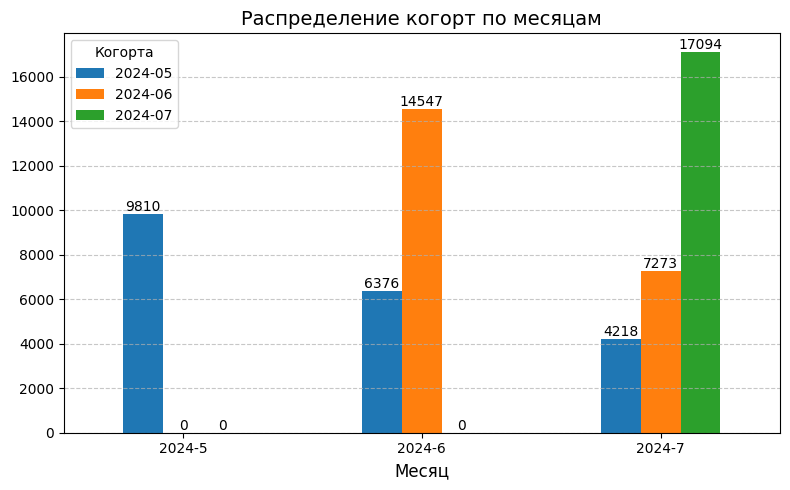

In [4]:
# Создание сводной таблицы
pivot_table = pd.pivot_table(df, index='cohort', columns='month', values='uuid', aggfunc='nunique')
pivot_table.fillna(0, inplace=True)
pivot_table = pivot_table.astype(int)
display(pivot_table)

# считаем суммы
pivot_table['SumCohort'] = pivot_table.sum(axis=1)
pivot_table.loc['SumMonth'] = pivot_table.sum().astype(int)
display(pivot_table)

data_for_plot = pivot_table.drop('SumMonth') # Исключаем строку SumMonth
data_for_plot = data_for_plot.iloc[:, :-1].T  # Исключаем колонку SumCohort

ax = data_for_plot.plot(kind='bar', figsize=(8, 5))
plt.title('Распределение когорт по месяцам', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Когорта', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')  # Отображаем целые числа

plt.show()

month,2024-5,2024-6,2024-7
cohort,,,
2024-05,70,90,72
2024-06,0,67,67


month,2024-5,2024-6,2024-7,SumCohort
cohort,,,,
2024-05,70,90,72,232
2024-06,0,67,67,134
SumMonth,70,157,139,366


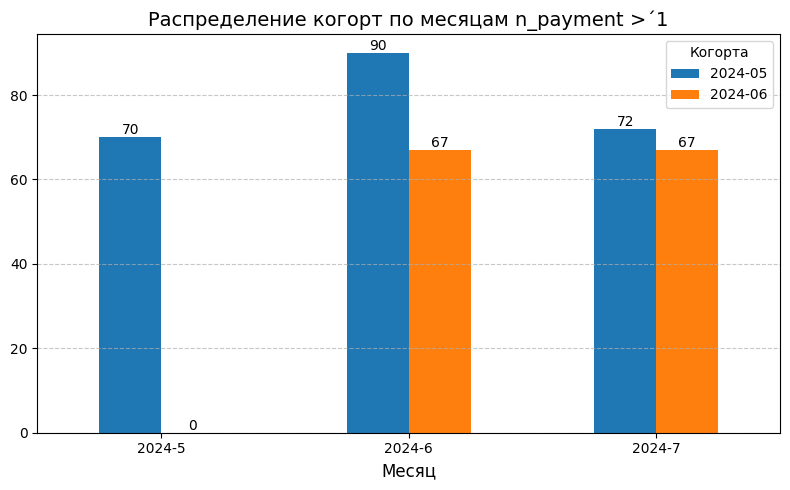

In [5]:
# Создание сводной таблицы
df1 = df[df.n_payment >1]
pivot_table = pd.pivot_table(df1, index='cohort', columns='month', values='uuid', aggfunc='nunique')
pivot_table.fillna(0, inplace=True)
pivot_table = pivot_table.astype(int)
display(pivot_table)

# считаем суммы
pivot_table['SumCohort'] = pivot_table.sum(axis=1)
pivot_table.loc['SumMonth'] = pivot_table.sum().astype(int)
display(pivot_table)

data_for_plot = pivot_table.drop('SumMonth') # Исключаем строку SumMonth
data_for_plot = data_for_plot.iloc[:, :-1].T  # Исключаем колонку SumCohort

ax = data_for_plot.plot(kind='bar', figsize=(8, 5))
plt.title('Распределение когорт по месяцам n_payment >´1', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.xticks(rotation=0)
plt.legend(title='Когорта', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', label_type='edge')  # Отображаем целые числа

plt.show()